<h1 style = "font-family:Verdana;text-align:center;font-size:250%"> Embedding analogy visualization </h1>

## Read pretrained embeddings


In [1]:
import numpy as np
from gensim import models

#for tables in Jupyter
from IPython.display import HTML, display
import tabulate

#for visualization
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sPCA
from sklearn import manifold #MSD, t-SNE

In [2]:
import os
import pandas as pd
import numpy as np
import sent2vec
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
import csv

#NLTK
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from scipy.spatial.distance import cosine as dist
from scipy.spatial.distance import euclidean
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string

#gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from utilsBio import *
from utilsLSTM import *
from SentimenSD import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


/data/h.grissette/SA/Paper


In [3]:
tweet_covid = pd.read_csv(os.path.join("..","COVID19/Twitter_COVID19_data/tweets_covid19_cleaned.csv"))
tweet_epilepsy = pd.read_csv(os.path.join("..", "Samples/epilepsy_texts.csv"), header=None)
tweet_epilepsy = tweet_epilepsy.drop_duplicates().reset_index(drop=True)
sentences = tweet_epilepsy[1]
# sentences = sentences.append(tweet_covid.clean_text[2:], ignore_index=True)
# sentences =tweet_epilepsy[1]
sentences[2]
freq=len(sentences)

In [ ]:
w2v_google = KeyedVectors.load_word2vec_format(file_path+'/datasets/GoogleNews-vectors-negative300.bin.gz', binary=True,encoding="ISO-8859-1")
bio_word2vec = KeyedVectors.load_word2vec_format(file_path+'/datasets/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True,encoding="ISO-8859-1")
Embeddings_bio_word2vec, ignored_words_bio=create_embedding_w2v(bio_word2vec,sentences,200)
Embeddings_google, ignored_words_google = create_embedding_w2v(w2v_google,sentences,300)
print(" ignored words google model : "+str(len(ignored_words_google)))
print(" ignored words bioword2vec model : "+str(len(ignored_words_bio)))
# Load Embedding concept from PubMed
w2v_concept_cbow = KeyedVectors.load_word2vec_format(file_path+'/datasets/bioconceptvec_word2vec_cbow.bin', binary=True,encoding="ISO-8859-1")
embedd_concepts_cbow, ignored_concept_cbow = create_embedding_w2v(w2v_concept_cbow,sentences,100)
embedd_concepts_cbow[3]
# print(len(ignored_concept_cbow)) #66609
embeddings_glove = load_Glove(file_path+"/datasets/glove.840B.300d.txt")
embedding_matrix_glove,words_ignored_glove = create_embedding_glove(embeddings_glove,sentences,300)
# print(len(words_ignored_glove)) 

Total words 13595
6543 words ignored
(13595, 200)
Total words 13595
7441 words ignored
(13595, 300)
 ignored words google model : 7441
 ignored words bioword2vec model : 6543
Total words 13595
6568 words ignored
(13595, 100)


In [19]:
s = SentimentSD(filename=os.path.join('..','Word_Sense_Disambiguation_projects/Simple_WSD_SA/SentiWordNet_3.0.0.txt'),weighting='geometric')
# data_adrs = pd.read_csv('adrs.csv')
# results = {}
# for i in range(len(sentences)):
#     results[data_adrs.sentence[i]] = s.score(data_adrs.sentence[i])
# results = pd.DataFrame(results.items(),columns=['Tweet','sentiment'])
# results.to_csv('adrs_sentiment.csv')
# results
data = {}
for i in range(len(sentences)):
    data[sentences[i]] = s.score(sentences[i])
data = pd.DataFrame(data.items(),columns=['sentence','sentiment'])
# results.to_csv('adrs_sentiment.csv')
data

,sentence,sentiment
0,@amepilepsysoc terrific leadership team great ...,-0.038462
1,@amepilepsysoc used interactive program plan #...,0.010417
2,epilepsy nurses using tec gather data quolie 1...,0.005208
3,@yellasunshine family suffered huge loss passi...,-0.045455
4,@amundanesarah every day struggle disability #...,-0.062500
...,...,...
4396,@jenfol2000 rough time last night son due epil...,-0.035714
4397,@angelnat7 #pretty picture #me blessing &lt;3 ...,0.057692
4398,paicipating #getdownforepilepsy challenge - da...,0.069444
4399,@_michelleserna glad youre ok fall great attit...,-0.005208


In [20]:
len(sentences)

8623

In [21]:
# print(len(tokenizer.word_index))
# len(sentences)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
# word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences,padding='post')
# print(sequences)


vocab_size= len(word_index)
max_length=120
embedding_dim= 16
trunc_type = 'post'
oov_tok="<OOV>"
training_data = data.sentence[0:5500]
training_labels= data.sentiment[0:5500]

testing_data=data.sentence[5500:len(sentences)]
testing_labels= data.sentiment[5500:len(sentences)]

tokenizer = Tokenizer(num_words= vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_data)
padded = pad_sequences(sequences, maxlen=max_length,truncating= trunc_type)

testing_sequences= tokenizer.texts_to_sequences(testing_data)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [24]:
from tensorflow.keras.utils import to_categorical
num_epochs = 10
maxlen = len(max(sentences, key = len).split())
#     num_classes = len(training_data['sentiment'].unique())
num_classes = len(training_labels.unique())
print('num_classes : ',num_classes)
maxLen = max([len(s) for s in sentences])
X_train_indices = padded 
Y_train_oh = to_categorical(training_labels,num_classes) 

num_classes :  240


In [ ]:
from tensorflow.keras import layers
embedding_layer, ignored_words = pretrained_embedding_layer(bio_word2vec,w2v_concept_cbow,embeddings_glove,word_index,300)
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(num_classes), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()


#shape: (vocab_size, embedding_dim)
print(weights.shape)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)
model.fit(padded,training_labels,
         epochs=num_epochs,
         validation_data=(testing_padded,testing_labels))
model.save_weights("vectors.h5") 
e = model.layers[0] 
weights = e.get_weights()[0]

In [27]:
padded

array([[   0,    0,    0, ...,   24,  106, 6106],
       [   0,    0,    0, ...,  389,  743,  619],
       [   0,    0,    0, ...,  311, 2560, 6110],
       ...,
       [   0,    0,    0, ...,    4,   10, 4543],
       [   0,    0,    0, ...,   94,  106,   59],
       [   0,    0,    0, ...,  629,  286,    1]], dtype=int32)

In [ ]:
word_index[1:10]

## Background

Visualizing data often helps us understand it better, whether as an overview or at a more detailed level. Word vector models pose several significant problems for visualization, however.

The first problem has to do with the size of the vocabulary. Even with these small corpora, the size of the vocabulary makes it difficult to visualize it all at once. (The smallest text in the [previous experiment](wvecs_testsets_parameters.nb.html), _Nightmare Abbey_, has just under 5,000 types, while the largest text, _Moby Dick_, has almost 18,000 types).

The second problem has to do with the number of dimensions of the vector spaces. Our test parameters range from 25 to 400. Given that we visualize information in two or three dimensions (perhaps with time as a fourth), we have many more dimensions of information than we have available for the visualization. Even standard visualization encoding techniques (color, shape, etc.) give us just a few more dimensions to use, and their expressibility is relatively limited.

The third problem has to do with the nature of the axes of the vector spaces. For most vector space models, including the three discussed in this series of posts (ppmi_svd, word2vec, and FastText), the axes do not have any inherent meaning. This lack of meaning makes it difficult to use those axes in a visualization.

To address the problem of the size of the vocabulary, we can note that for most of the tasks involving word vectors, we are not interested in the whole vocabulary at once. [For example](wvecs_exploring_similarities.nb.html), we might be interested in the closest items to a relatively small set of words. I will thus set aside the issue of vocabulary size, and focus on the number of dimensions and interpretatibily issues.

In the examples here, I will use a centroid word2vec model for _Vanity Fair_ that we created in the post on [stabilizing randomness](wvecs_random_fix.html). The parameters are win=10, dim=100, min_count=10. There is nothing special about these parameters, nor about the use of word2vec &mdash; other parameters and other techniques would work just as well.

In [30]:
# vf = 'vanity_fair_pg599.txt-sents-clean.txt-word2vec-win10-dim100-thresh10.vecs'
# vecs = models.KeyedVectors.load(vf)
w2v_google.init_sims(True)
# embeddings_glove.init_sims(True)
w2v_concept_cbow.init_sims(True)
bio_word2vec.init_sims(True)

## Dimensions and similarity

### Similarity lines

Probably the most common use of visualization of word vectors is to get a sense of how similar words are. In the post on [exploring similarities](wvecs_exploring_similarities.nb.html), we used one (uncommon) technique for visualizing similarties, namely plotting rank vs. similarity. (We then used the slope of those lines for further analysis, but that is not the point here.) Below we see the similarity line for the 10 words most similar to 'house'.

In [45]:
w2v_google.init_sims(True)
embeddings_glove.init_sims(True)
w2v_concept_cbow.init_sims(True)
bio_word2vec.init_sims(True)

from visualize_embed import *

In [46]:
w2v_google.init_sims(True)
embeddings_glove.init_sims(True)
w2v_concept_cbow.init_sims(True)
bio_word2vec.init_sims(True)

from visualize_embed import *
def show_closest_line(vecs,word,n):
    display(HTML("<b>%d words most similar to '%s'</b>" % (n,word)))
    
    tops = vecs.similar_by_word(word, topn=n, restrict_vocab=None)
    
    items = [item[0] for item in tops]
    sims = [item[1] for i,item in enumerate(tops)]
    
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)

    
    plt.xticks(range(n), [i+1 for i in range(n)])
    plt.xlabel('Rank')
    plt.ylabel('Similarity')
    plt.xlim(-1,n)

    
    ax.plot(sims, color="purple", alpha=0.5)
    
    for item, x, y in zip(items, range(n), sims):
        ax.annotate( item, xy=(x, y), xytext=(20, -7), textcoords='offset points', 
                     ha='right', va='bottom', color='orange', fontsize=14 )

    
    
    
    plt.show()

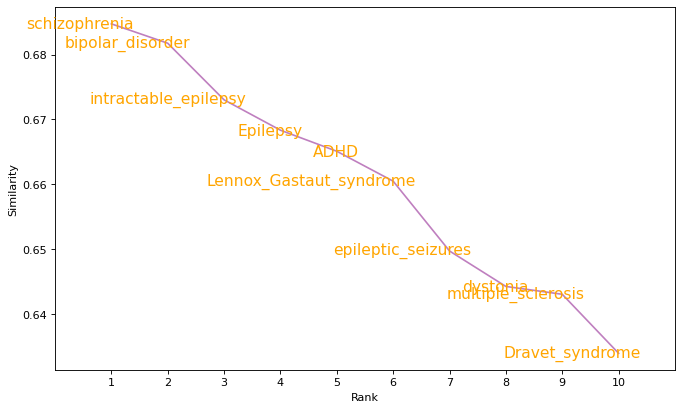

In [8]:
show_closest_line(w2v_google,'epilepsy',10)

In [10]:
# embeddings_glove
# show_closest_line(embeddings_glove,'epilepsy',10)
# w2v_concept_cbow
show_closest_line(w2v_concept_cbow,'epilepsy',10)

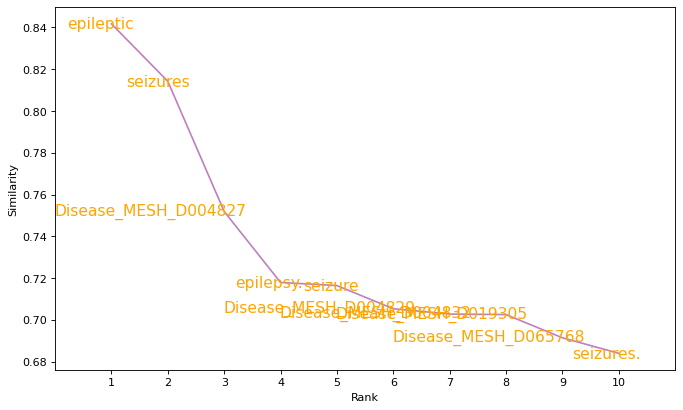

In [13]:
# w2v_concept_cbow
show_closest_line(w2v_concept_cbow,'epilepsy',10)

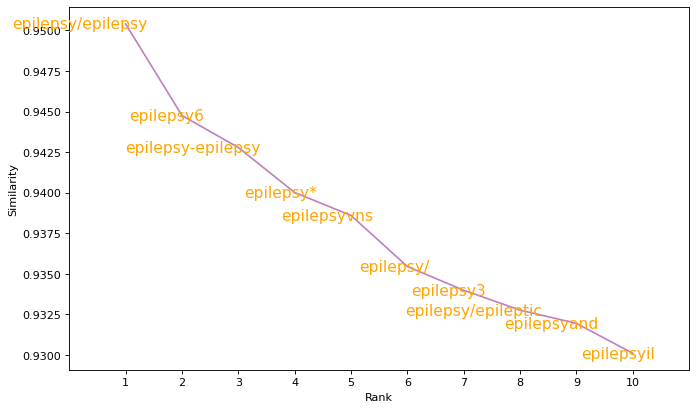

In [14]:
# bio_word2vec
show_closest_line(bio_word2vec,'epilepsy',10)
# embeddings_glove
# show_closest_line(embeddings_glove,'epilepsy',10)
# w2v_concept_cbow
show_closest_line(w2v_concept_cbow,'epilepsy',10)

In [38]:
word_index['king']

3557

In [42]:
idx = [word_index[word] for word in words]
idx

[3557, 3262, 148, 890]

(4, 300) [3557, 3262, 148, 890]


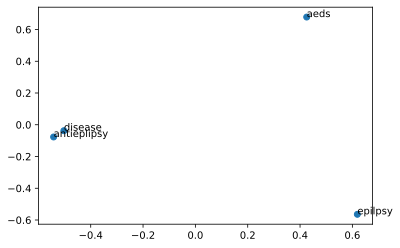

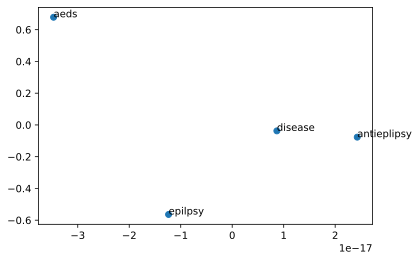

In [48]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['epilpsy', 'aeds','disease','antieplipsy',"corona",""]
# given a list of words and the embeddings, it returns a matrix with all the embeddings
embedding_matrix = np.zeros((len(word_index.keys()), 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_google:
        embedding_matrix[i] = w2v_google[word]
X = embedding_matrix[idx, :]         
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()

A large advantage of similarity lines is that they are easily interpretable: rank and similarity are familiar ideas and they are encoded straightforwardly by position (horizontal and vertical, respectively).

The main disadvantage of similarity lines is that show us only one aspect of similarity, namely similarity to a single given word ('house' in this example). We cannot tell anything about the similarity of these words _to each other_. 

To see why this is so, consider a geographic example. The distance from London, England to the closest European capital, Paris, France, is 460km, while the distance from London to the second closest European capital, Dublin, Ireland, is 557km. However, the distance from Paris to Dublin is not 97km (557-460), but rather 1024km.

<div style="margin-left:3em">
Dublin <span style="font-size:2em">⟷</span> London <span style="font-size:2em">⟷</span> Paris
</div>

The problem is that in both the geographic example and word vectors, distance/similarity is one dimensional but the data is multi-dimensional (location involves orientation, not just distance), so some information is lost when representing the original data with a single dimension.


### Dimensionality reduction techniques

A common technique when dealing with high dimensionsal data is to _reduce_ the number of dimensions by transforming the data into a lower number of _new_ dimensions for visualization. The number of dimensions is usually two, sometimes three, given our two dimensional displays. There are many ways to do dimensionality reduction, each with their own goals and motivations, but I will focus on three common techniques, using just two dimensions for illustration.


* Principal Components Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis))
* Multidimensional Scaling ([MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling))
* t-distributed Stochastic Neighbor Embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding))

It is important to note that these techniques are mathematical transformations and not visualization techniques: the _results_ of the transformations are _used_ for visualization. In fact, the function I wrote below to illustrate these techniques calculates the transformation in each case, and then uses exactly the same code for the visualizations.

An additional point is that the new dimensions of the transformed data do not have any inherent meaning relative to the original data, which is why there are no scales in the charts below.

In [82]:
def show_closest_2d(vecs,word,n,method):
    tops = vecs.similar_by_word(word, topn=n, restrict_vocab=None)
    
    display(HTML("<b>%d words most similar to '%s' (%s)</b>" % (n,word, method)))
    #display(HTML(tabulate.tabulate(tops, tablefmt='html', headers=[])))

    items = [word] + [x[0] for x in tops]

    wvecs = np.array([vecs.word_vec(wd, use_norm=True) for wd in items])

    if method is "PCA":
        spca = sPCA(n_components=2)
        coords = spca.fit_transform(wvecs)
        #print('Explained variation per principal component:', spca.explained_variance_ratio_, "Total:", sum(spca.explained_variance_ratio_))
    
    elif method is "tSNE":
        tsne = manifold.TSNE(n_components=2)
        coords = tsne.fit_transform(wvecs)
        #print("kl-divergence: %0.8f" % tsne.kl_divergence_)
        
    elif method == "tSNE-PCA":
        tsne = manifold.TSNE(n_components=2, init='pca')
        coords = tsne.fit_transform(wvecs)
        #print("kl-divergence: %0.8f" % tsne.kl_divergence_)
    
    elif method is "MDS":
        dists = np.zeros((len(items), len(items)))
        for i,item1 in enumerate(items):
            for j,item2 in enumerate(items):
                dists[i][j] = dists[j][i] = vecs.distance(item1,item2)
        
        mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=0, dissimilarity="precomputed", n_jobs=1)
        coords = mds.fit(dists).embedding_
        #print("Stress is %0.8f" % mds.stress_)

    else:
        raise ValueError("Invalid method: %s" % method) 

    plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        left=False,         
        labelbottom=False,
        labelleft=False)

    lim = max([abs(x) for x in coords[:,0] + coords[:,1]])
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.scatter(coords[2:,0], coords[2:,1])
    plt.scatter(coords[0:1,0], coords[0:1,1], color='black')
    plt.scatter(coords[1:2,0], coords[1:2,1], color='orange')
    
    for item, x, y in zip(items[2:], coords[2:,0], coords[2:,1]):
        plt.annotate( item, xy=(x, y), xytext=(-2, 2), textcoords='offset points', 
                     ha='right', va='bottom', color='purple', fontsize=14 )

    x0=coords[0,0]
    y0=coords[0,1]
    plt.annotate( word , xy=(x0, y0), xytext=(-2, 2), textcoords='offset points', 
                 ha='right', va='bottom', color='black', fontsize=16 )
    
    x1=coords[1,0]
    y1=coords[1,1]
    plt.annotate( items[1] , xy=(x1, y1), xytext=(-2, 2), textcoords='offset points', 
                 ha='right', va='bottom', color='orange', fontsize=14 )

    ax = plt.gca()
    
    r = math.sqrt( (x1-x0)**2 + (y1-y0)**2 )
    
    circle = plt.Circle((x0, y0), r, color='orange', fill=False)
    ax.add_artist(circle)
    plt.savefig("fig1.png")
    plt.show()

#### Principal Components Analysis (PCA)

The goal of PCA is to transform the original data into a representation using fewer, independent dimensions such that each successive dimension maximizes the variance of the information encoded in that new axis. Here is an example showing the 10 words most similar to 'house' in this word2vec model. 

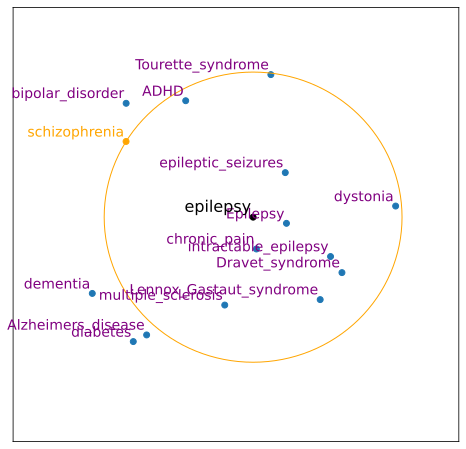

In [83]:
show_closest_2d(w2v_google,'epilepsy',15,'PCA')

We saw in the similarity line example above, that 'lane' is the word most similar to 'house' in this vector space. However, in the new PCA dimensions, 'lane' is not the closest to 'house', but 'admitted' is. In addition, a second word 'hampshire' (_Hampshire_) is also closer to 'house' than 'lane' is. This discrepancy is due to the fact that PCA does not preserve distances (or even have that as a goal). This mismatch between similarity and the two-dimensional representations of the vector space is an inherent one: it is not possible to preserve _all_ the distances from a higher dimensional space in a lower one.

#### Multidimensional Scaling (MDS)

Unlike PCA, MDS _does_ try to preserve distances. Here is what the 10 words most similar to 'house' look like under MDS. The word 'admitted' is still closer to 'house' than 'lane', but only barely, and it is the only word closer than 'lane'.

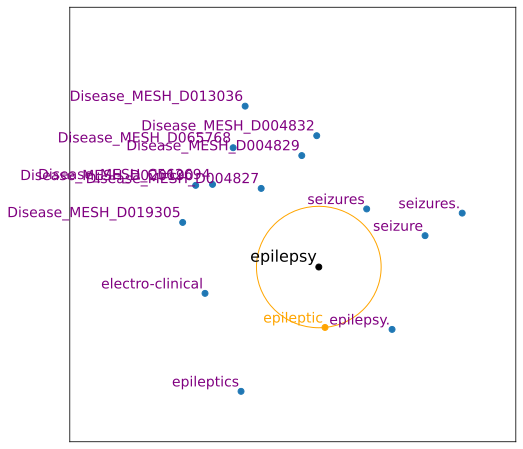

In [92]:
show_closest_2d(w2v_google,'epilepsy',15,'PCA')
show_closest_2d(w2v_google,'epilepsy',15,'MDS')

#### t-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE also tries to preserve distances. Where MDS tries to preserve "close" distances, t-SNE tries to preseve both "close" and "far" distances. Here is what the 10 words most similar to 'house' look like under t-SNE.

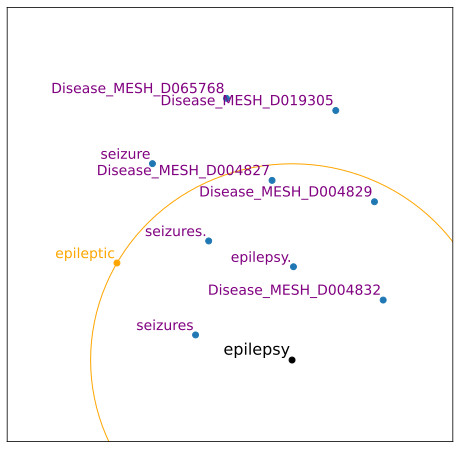

In [91]:
show_closest_2d(w2v_concept_cbow,'epilepsy',10,'tSNE')


Since t-SNE is stochastic, it can give different results every time it is used with exactly the same data and parameters. Here is another output.

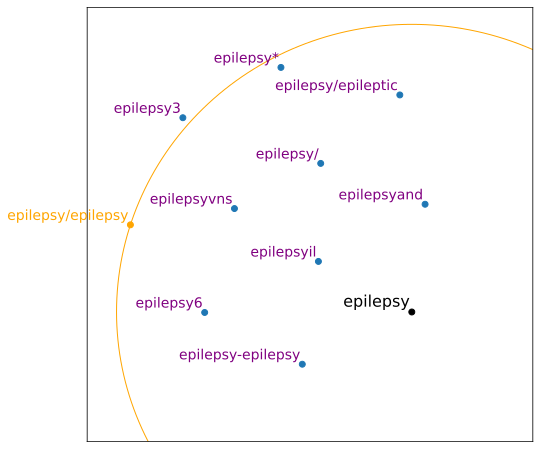

In [87]:
show_closest_2d(bio_word2vec,'epilepsy',10,'tSNE')

However, it is also possible to combine t-SNE with PCA and have a (more) stable outcome. Here is an example of the same 10 words most similar to 'house'. Note that 'park' is roughy the same distance from 'house' as 'lane' even though 'lane' is the closet word to 'house' and 'park' is the 6th-closest.

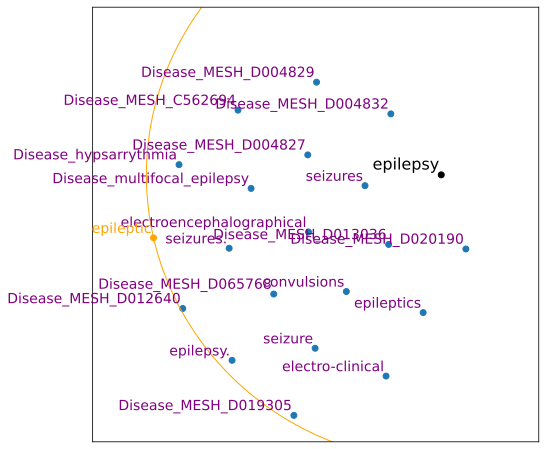

In [95]:
show_closest_2d(w2v_concept_cbow,'epilepsy',20,'tSNE-PCA')

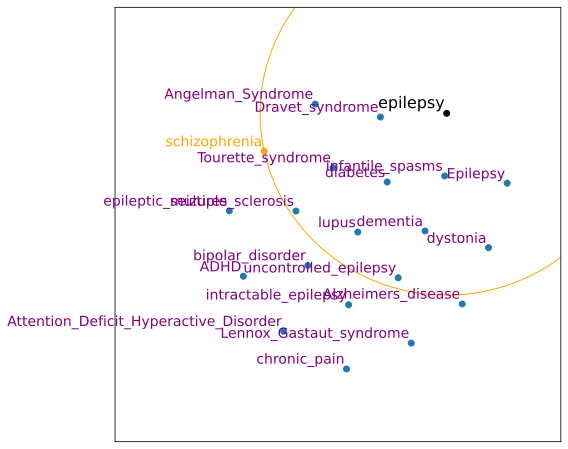

In [96]:
show_closest_2d(w2v_google,'epilepsy',20,'tSNE-PCA')

#### Evaluating dimensionality reduction techniques

The main advantage of using dimensionality reduction is that the results can give us an idea of _groupings_ of words in a way that the similarity lines cannot. However, given that it is in general impossible to preserve _all_ of the distances in a high dimensional space when we reduce it down to a lower number of dimensions, the groupings we see in the reduced version must be taken with a grain of salt, as can be seen from the differences across the different techniques. The choice of dimensionality reduction technique thus depends on external factors, such as speed. It might also be prudent to try more than one, as we have done here.

Incidentally, this issue with dimensionality reduction raises the issue of the appropriateness of the visualizations commonly used to show language change using word vectors (e.g. [[1]](#ref1), [[2]](#ref2), [[3]](#ref3), since they use dimensionality reduction to create the two-dimensional visualizations.

## Visualizing the vectors

The previous section was concerned with visualizing words to see similarities. The actual values of the word vectors were not relevant. In this section, we will explore a couple ways to visualize the values.

However, we need to be careful in how we use these visualizations, since dimensions do not have any inherent meaning. The most we can do is use these visualizations to _compare_ vectors, to see which components have similar values and which don't.

For the purposes of these visualizations, I am using normalized vectors (so the *length* of each vector is 1. This is also true of the preceding visualizations, but it was not relevant, since we were dealing with similarities of whole vectors, not the components of the vectors.

### Encoding with color

One simple way to visualize the components of vectors is to assign each value a color, and then show them as shapes along a horizontal axis, representing the dimensions. In the first example below, we'll use 'house' and some of its most similar words, from the example above.

In [56]:
def compare_words_with_color(vecs,wds):
    wdsr = wds[:]
    wdsr.reverse()
    
    display(HTML('<b>Word vectors for: %s</b>' % ', '.join(wdsr)))
    
    vs = [vecs.get_vector(wd) for wd in wds]
    dim = len(vs[0])
    
    fig = plt.figure(num=None, figsize=(12, 2), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_facecolor('gray')
    
    for i,v in enumerate(vs):
        ax.scatter(range(dim),[i]*dim, c=vs[i], cmap='Spectral', s=16)
    
    #plt.xticks(range(n), [i+1 for i in range(n)])
    plt.xlabel('Dimension')
    plt.yticks(range(len(wds)), wds)
    
    
    plt.show()

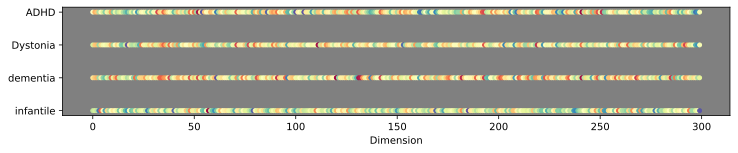

In [70]:
words_epilepsy = ['ADHD', 'Dystonia', 'dementia', 'infantile']
words_epilepsy.reverse()
compare_words_with_color(w2v_google,words_epilepsy)

Impressionistcally, there is a lot of similartiy in the values of the components, not surprisingly. On the other hand, when we look at words that are semantically related ('woman','girl','lady','man'), it's harder to see similarities is the values, though dimension 60 stands out.

In [97]:
words = ['bipolar','Epilepsy','spasm','sudep','ADHD', 'Dystonia', 'dementia']
words.reverse()

In [ ]:
# compare_words_with_color(w2v_google,words)

### Encoding as polylines

In the color encoding technique, the dimensions are represented on the horizontal axis, while the values are represented by color. An alternative for the values is the represent them on the vertical axis, connecting the components of a single vector by line segments (a polyline). This technique borrows from the [parallel coordinates visualization](https://en.wikipedia.org/wiki/Parallel_coordinates). Once again, the difference here is that unlike typical uses of parallel coordinates, our components/axes do not have any inherent meaning.

Here's a version in parallel coordinates style, with all the vectors represented in the same chart.

In [73]:
def compare_words_polyline(vecs,wds,combined=True):
    
    display(HTML('<b>Word vectors for: %s</b>' % ', '.join(wds)))
    
    vs = [vecs.get_vector(wd) for wd in wds]
    dim = len(vs[0])
    nseries = len(wds)

    colormap = plt.cm.tab20b
    colors = [colormap(i) for i in np.linspace(0, 1, nseries)]

    
    if combined:
        fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)

        for i,v in enumerate(vs):
            ax.plot(v, label=wds[i], c=colors[i])

        ax.legend(loc=2)
        
    else:
        fig, axarr = plt.subplots(nseries+1, sharex=True, sharey=True, figsize=(12, 2+nseries), dpi=80, facecolor='w', edgecolor='k')

        for i,v in enumerate(vs):
            axarr[i+1].plot(v, label=wds[i], c=colors[i])
        
        axarr[0].axis('off')
        
        fig.legend(loc=9)
        fig.tight_layout()
 

    plt.xlabel('Dimension')
    plt.ylabel('Value')
    
    plt.show()
    

In [74]:
words2 = words[:]
words2.reverse()

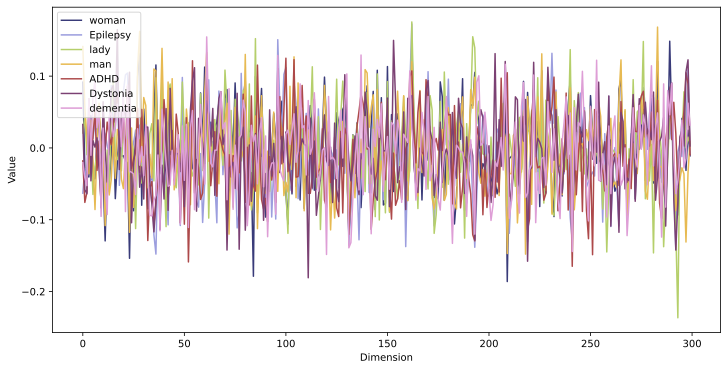

In [75]:
compare_words_polyline(w2v_google,words2)

However, I find these examples easier to understand if each vector is own chart, as in the following:

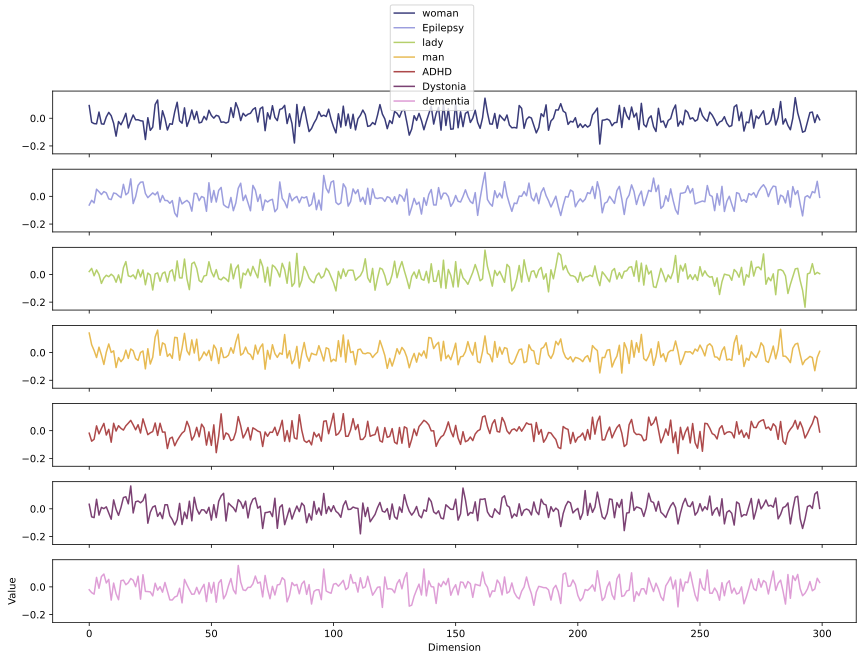

In [77]:
compare_words_polyline(w2v_google,words2,combined=False)

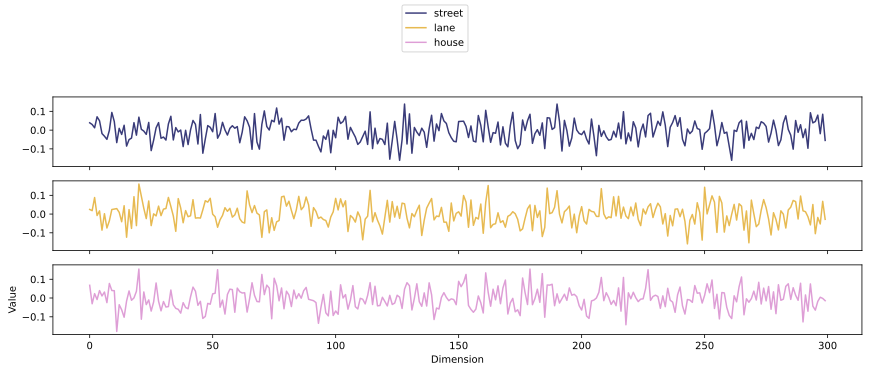

In [78]:
words_house2 = words_house[:]
words_house2.reverse()
compare_words_polyline(w2v_google, words_house, combined=False)

One potential drawback to the polyline approach is that we tend to interpret the lines as representing an ordered sequence, while the dimensions have no inherent order (in addition to having no inherent meaning). As long we we keep this caveat in mind, the polylines are a reasonable way to _compare_ vectors.

While the choice of technique for visualizing the vector component values is largely a personal preference, the polyline approach allows for a finer grained comparison, while the color encoding approach perhaps gives a more holistic impression. 

## Discussion and Conclusion

While visualization can be a powerful tool in understanding data, we have seen that there is no ideal technique. Each one has its advantages and disadvantages, and we have to be careful in understanding what they represent, and particularly in the case of dimensionality reduction, the lack of complete fidelity of distances to the original.

Finally, we can note that since we are not trying to consider all the vocabulary at once, or even large parts of it, these visualization techniques can be applied to any word vector model.

[Back to the introduction](wvecs_intro.html)

Other posts

* [Stabilizing randomness](wvecs_random_fix.html)
* [A new measure for evaluation](wvecs_evaluation_measure.html)
* [Finding useful parameters and methods](wvecs_testsets_parameters.nb.html)
* [Exploring similarities](wvecs_exploring_similarities.nb.html)


## References
<span id="ref1">[1]</span> Vivek Kulkarni, Rami Al-Rfou, Bryan Perozzi, and Steven Skiena. 2014. Statistically significant detection of linguistic change. In Proc. 24th WWW Conf., pp. 625–635. International World Wide Web Conferences Steering Committee.

<span id="ref2">[2]</span> William L. Hamilton, Jure Leskovec, and Dan Jurafsky. 2016. Diachronic word embeddings reveal historical laws of semantic change. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers).

<span id="ref3">[3]</span> Terrence Szymanski. 2017. Temporal Word Analogies: Identifying Lexical Replacement with Diachronic Word Embeddings. Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (Short Papers), pp. 448–453.